1. SETUP AND DATA LOADING

In [20]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # Import joblib to save and load models and vectorizers
import shutil # Import shutil for file operations
from google.colab import files # Import files for downloading

# Scikit-learn imports for vectorization and models
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE # Import TSNE for visualization

# TensorFlow and Keras imports for the Deep Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.datasets import imdb

In [2]:
print("Downloading NLTK stopwords...")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
print("Loading IMDb dataset...")
num_words = 10000  # Consider the top 10,000 most frequent words
(X_train_int, y_train), (X_test_int, y_test) = imdb.load_data(num_words=num_words)

Loading IMDb dataset...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Get the word index and create reverse mapping
word_index = imdb.get_word_index()
reverse_word_index = {v: k for k, v in word_index.items()}

# --- Function to decode reviews from integers to text ---
def decode_review(text_int):
    # The indices are offset by 3 because 0, 1, and 2 are reserved indices for
    # "padding", "start of sequence", and "unknown".
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in text_int])

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
# Decode the training and testing sets
print("Decoding integer sequences back to text reviews...")
X_train_text = [decode_review(review) for review in X_train_int]
X_test_text = [decode_review(review) for review in X_test_int]

print(f"\nSuccessfully loaded and decoded {len(X_train_text)} training samples and {len(X_test_text)} testing samples.")
print("\nSample review:\n", X_train_text[0])
print("\nSample label:", y_train[0], "(1 for Positive, 0 for Negative)")

Decoding integer sequences back to text reviews...

Successfully loaded and decoded 25000 training samples and 25000 testing samples.

Sample review:
 ? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play

2. DATA CLEARNING AND PREPROCESSING

In [6]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# --- Create a function to clean and preprocess the text ---
def preprocess_text(text):
    # Remove HTML tags (like <br />)
    text = re.sub(r'<.*?>', '', text)
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z]', ' ', text).lower()
    # Tokenize the text
    words = text.split()
    # Remove stop words and apply stemming
    processed_words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(processed_words)

# --- Apply the preprocessing function to the datasets ---
# This step can take a few minutes.
print("\nPreprocessing text data (cleaning, stop-word removal, stemming)...")
X_train_processed = [preprocess_text(review) for review in X_train_text]
X_test_processed = [preprocess_text(review) for review in X_test_text]

print("Preprocessing complete.")
print("\nSample processed review:\n", X_train_processed[0])


Preprocessing text data (cleaning, stop-word removal, stemming)...
Preprocessing complete.

Sample processed review:
 film brilliant cast locat sceneri stori direct everyon realli suit part play could imagin robert amaz actor director father came scottish island love fact real connect film witti remark throughout film great brilliant much bought film soon releas would recommend everyon watch fli fish amaz realli cri end sad know say cri film must good definit also two littl boy play norman paul brilliant children often left list think star play grown big profil whole film children amaz prais done think whole stori love true someon life share us


3. VECTORIZATION AND MODEL TRAINING

3 vectorization models
 - Binary (with 3 grams)
 - Word-count (with 3 grams)
 - TF-IDF (with 3 grams)

In [7]:
import os

In [8]:
# --- Helper function to calculate performance metrics from the paper ---
def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    positive_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    negative_precision = tn / (tn + fn) if (tn + fn) > 0 else 0
    return {
        "Accuracy": accuracy,
        "Positive Precision": positive_precision,
        "Negative Precision": negative_precision,
        "Confusion Matrix": (tn, fp, fn, tp)
    }

# --- Create a directory to store models ---
models_dir = 'trained_models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
else: # Clean out the directory if it exists to avoid using old models
    shutil.rmtree(models_dir)
    os.makedirs(models_dir)

In [9]:
# --- Store all results in a list for final summary ---
results_list = []

# --- Define vectorizers ---
vectorizers = {
    "Binary, 3-grams": CountVectorizer(ngram_range=(1, 3), binary=True, max_features=num_words),
    "Word-Count, 3-grams": CountVectorizer(ngram_range=(1, 3), binary=False, max_features=num_words),
    "TF-IDF, 3-grams": TfidfVectorizer(ngram_range=(1, 3), max_features=num_words)
}

In [12]:
# --- Main loop for training, evaluation, and saving ---
# Store fitted vectorizer objects for later use (e.g., t-SNE visualization)
vectorizer_objects = {}

for vec_name, vectorizer in vectorizers.items():
    print(f"\n{'='*20} Using Vectorizer: {vec_name} {'='*20}")

    # --- Vectorize the data ---
    print("Fitting and transforming data...")
    X_train_vec = vectorizer.fit_transform(X_train_processed)
    X_test_vec = vectorizer.transform(X_test_processed)

    # Store the fitted vectorizer object
    vectorizer_objects[vec_name] = {'vectorizer': vectorizer, 'test_vectors': X_test_vec}

    # --- Save the fitted vectorizer ---
    vec_filename = f"{vec_name.replace(', ', '_').replace('-', '_')}_vectorizer.joblib"
    vectorizer_path = os.path.join(models_dir, vec_filename)
    joblib.dump(vectorizer, vectorizer_path)
    print(f"Vectorizer saved to: {vectorizer_path}")

    # --- Define models to be trained ---
    models = {
        "Logistic Regression": LogisticRegression(C=1.0, penalty='l2', solver='liblinear', tol=1e-4),
        "SVM": SVC(C=1.0, kernel='linear'),
        "Naïve Bayes": MultinomialNB(alpha=1.0),
        "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, n_jobs=-1),
        "Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, min_samples_split=2)
    }

    # Train, evaluate, and save traditional ML models
    for model_name, model in models.items():
        print(f"\n--- Training {model_name} ---")
        model.fit(X_train_vec, y_train)
        y_pred = model.predict(X_test_vec)

        # --- Save the trained model ---
        model_filename = f"{vec_name.replace(', ', '_').replace('-', '_')}_{model_name.replace(' ', '_')}.joblib"
        model_path = os.path.join(models_dir, model_filename)
        joblib.dump(model, model_path)
        print(f"Model saved to: {model_path}")

        metrics = calculate_metrics(y_test, y_pred)
        print(f"Results for {model_name}:")
        print(f"  Accuracy: {metrics['Accuracy']:.4f}")
        print(f"  Positive Precision: {metrics['Positive Precision']:.4f}")
        print(f"  Negative Precision: {metrics['Negative Precision']:.4f}")
        results_list.append({
            "Algorithm": model_name,
            "Vectorization": vec_name,
            **metrics
        })

    # --- Train, evaluate, and save the Deep Neural Network (DNN) ---
    print("\n--- Training Deep Neural Network (DNN) ---")
    X_train_dense = X_train_vec.toarray()
    X_test_dense = X_test_vec.toarray()

    dnn_model = Sequential([
        Dense(30, activation='relu', input_shape=(X_train_dense.shape[1],)),
        Dropout(0.5), Dense(30, activation='relu'), Dropout(0.5),
        Dense(20, activation='relu'), Dropout(0.5), Dense(10, activation='relu'),
        Dropout(0.5), Dense(10, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    dnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = dnn_model.fit(X_train_dense, y_train, epochs=20, batch_size=512, validation_split=0.2, callbacks=[early_stopping], verbose=1)

    # --- Save the trained DNN model ---
    dnn_filename = f"{vec_name.replace(', ', '_').replace('-', '_')}_DNN.h5"
    dnn_model_path = os.path.join(models_dir, dnn_filename)
    dnn_model.save(dnn_model_path)
    print(f"DNN Model saved to: {dnn_model_path}")

    # Evaluate DNN
    y_pred_proba = dnn_model.predict(X_test_dense)
    y_pred_dnn = (y_pred_proba > 0.5).astype(int).flatten()
    dnn_metrics = calculate_metrics(y_test, y_pred_dnn)
    print(f"Results for DNN:")
    print(f"  Accuracy: {dnn_metrics['Accuracy']:.4f}")
    print(f"  Positive Precision: {dnn_metrics['Positive Precision']:.4f}")
    print(f"  Negative Precision: {dnn_metrics['Negative Precision']:.4f}")
    results_list.append({"Algorithm": "Deep Neural Network", "Vectorization": vec_name, **dnn_metrics})


==================== Using Vectorizer: Binary, 3-grams ====================
Fitting and transforming data...
Vectorizer saved to: trained_models/Binary_3_grams_vectorizer.joblib

--- Training Logistic Regression ---
Model saved to: trained_models/Binary_3_grams_Logistic_Regression.joblib
Results for Logistic Regression:
  Accuracy: 0.8598
  Positive Precision: 0.8575
  Negative Precision: 0.8622

--- Training SVM ---
Model saved to: trained_models/Binary_3_grams_SVM.joblib
Results for SVM:
  Accuracy: 0.8284
  Positive Precision: 0.8284
  Negative Precision: 0.8285

--- Training Naïve Bayes ---
Model saved to: trained_models/Binary_3_grams_Naïve_Bayes.joblib
Results for Naïve Bayes:
  Accuracy: 0.8575
  Positive Precision: 0.8565
  Negative Precision: 0.8585

--- Training Random Forest ---
Model saved to: trained_models/Binary_3_grams_Random_Forest.joblib
Results for Random Forest:
  Accuracy: 0.8488
  Positive Precision: 0.8533
  Negative Precision: 0.8445

--- Training Boosting ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 0.5051 - loss: 0.6969 - val_accuracy: 0.5346 - val_loss: 0.6925
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5179 - loss: 0.6917 - val_accuracy: 0.5480 - val_loss: 0.6920
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.5422 - loss: 0.6865 - val_accuracy: 0.5860 - val_loss: 0.6908
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5559 - loss: 0.6815 - val_accuracy: 0.6696 - val_loss: 0.6860
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5953 - loss: 0.6710 - val_accuracy: 0.7446 - val_loss: 0.6754
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.6268 - loss: 0.6607 - val_accuracy: 0.7712 - val_loss: 0.6555
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6612 - loss: 0.6456 - val_accuracy: 0.7966 - val_loss: 0.6343
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.7035 - loss: 0.6274 - val_accuracy: 0.8014 -

DNN Model saved to: trained_models/Binary_3_grams_DNN.h5
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Results for DNN:
  Accuracy: 0.8653
  Positive Precision: 0.9024
  Negative Precision: 0.8345

==================== Using Vectorizer: Word-Count, 3-grams ====================
Fitting and transforming data...
Vectorizer saved to: trained_models/Word_Count_3_grams_vectorizer.joblib

--- Training Logistic Regression ---
Model saved to: trained_models/Word_Count_3_grams_Logistic_Regression.joblib
Results for Logistic Regression:
  Accuracy: 0.8545
  Positive Precision: 0.8576
  Negative Precision: 0.8515

--- Training SVM ---
Model saved to: trained_models/Word_Count_3_grams_SVM.joblib
Results for SVM:
  Accuracy: 0.8232
  Positive Precision: 0.8277
  Negative Precision: 0.8187

--- Training Naïve Bayes ---
Model saved to: trained_models/Word_Count_3_grams_Naïve_Bayes.joblib
Results for Naïve Bayes:
  Accuracy: 0.8462
  Positive Precision: 0.8552
  Negative Precision: 0.8377

--- Training Rand

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.5055 - loss: 0.6968 - val_accuracy: 0.5060 - val_loss: 0.6925
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5038 - loss: 0.6907 - val_accuracy: 0.5648 - val_loss: 0.6917
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5254 - loss: 0.6864 - val_accuracy: 0.6144 - val_loss: 0.6900
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5449 - loss: 0.6806 - val_accuracy: 0.6576 - val_loss: 0.6867
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.5711 - loss: 0.6722 - val_accuracy: 0.6942 - val_loss: 0.6808
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.5977 - loss: 0.6603 - val_accuracy: 0.7288 - val_loss: 0.6728
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6389 - loss: 0.6475 - val_accuracy: 0.7578 - val_loss: 0.6618
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6752 - loss: 0.6354 - val_accuracy: 0.7798 -

DNN Model saved to: trained_models/Word_Count_3_grams_DNN.h5
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Results for DNN:
  Accuracy: 0.8690
  Positive Precision: 0.8405
  Negative Precision: 0.9027

==================== Using Vectorizer: TF-IDF, 3-grams ====================
Fitting and transforming data...
Vectorizer saved to: trained_models/TF_IDF_3_grams_vectorizer.joblib

--- Training Logistic Regression ---
Model saved to: trained_models/TF_IDF_3_grams_Logistic_Regression.joblib
Results for Logistic Regression:
  Accuracy: 0.8838
  Positive Precision: 0.8799
  Negative Precision: 0.8878

--- Training SVM ---
Model saved to: trained_models/TF_IDF_3_grams_SVM.joblib
Results for SVM:
  Accuracy: 0.8808
  Positive Precision: 0.8809
  Negative Precision: 0.8807

--- Training Naïve Bayes ---
Model saved to: trained_models/TF_IDF_3_grams_Naïve_Bayes.joblib
Results for Naïve Bayes:
  Accuracy: 0.8525
  Positive Precision: 0.8540
  Negative Precision: 0.8510

--- Training Random Forest ---
Mo

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.5056 - loss: 0.6931 - val_accuracy: 0.5300 - val_loss: 0.6931
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5092 - loss: 0.6929 - val_accuracy: 0.5088 - val_loss: 0.6930
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5048 - loss: 0.6927 - val_accuracy: 0.5146 - val_loss: 0.6929
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5144 - loss: 0.6924 - val_accuracy: 0.5148 - val_loss: 0.6927
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5214 - loss: 0.6917 - val_accuracy: 0.5358 - val_loss: 0.6922
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5312 - loss: 0.6907 - val_accuracy: 0.5840 - val_loss: 0.6915
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5430 - loss: 0.6890 - val_accuracy: 0.6358 - val_loss: 0.6902
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5650 - loss: 0.6859 - val_accuracy: 0.6698 - v

DNN Model saved to: trained_models/TF_IDF_3_grams_DNN.h5
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Results for DNN:
  Accuracy: 0.8660
  Positive Precision: 0.8222
  Negative Precision: 0.9237


4. PACKAGE AND DOWNLOAD MODELS

In [17]:
print("\n\n{'='*25} PACKAGING MODELS FOR DOWNLOAD {'='*25}")

# Zip the directory containing all models and vectorizers
archive_name = 'trained_models_archive'
shutil.make_archive(archive_name, 'zip', models_dir)

print(f"All models and vectorizers have been saved and zipped into '{archive_name}.zip'.")
print("Starting download...")

# Trigger browser download
files.download(f'{archive_name}.zip')



{'='*25} PACKAGING MODELS FOR DOWNLOAD {'='*25}
All models and vectorizers have been saved and zipped into 'trained_models_archive.zip'.
Starting download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

5. RESULTS, SUMMARY AND VISUALIZATION



{'='*25} FINAL RESULTS SUMMARY {'='*25}
              Algorithm        Vectorization  Accuracy  Positive Precision  Negative Precision
0   Logistic Regression      Binary, 3-grams     0.860               0.857               0.862
1                   SVM      Binary, 3-grams     0.828               0.828               0.829
2           Naïve Bayes      Binary, 3-grams     0.857               0.856               0.858
3         Random Forest      Binary, 3-grams     0.849               0.853               0.845
4              Boosting      Binary, 3-grams     0.816               0.788               0.851
5   Deep Neural Network      Binary, 3-grams     0.865               0.902               0.834
6   Logistic Regression  Word-Count, 3-grams     0.855               0.858               0.852
7                   SVM  Word-Count, 3-grams     0.823               0.828               0.819
8           Naïve Bayes  Word-Count, 3-grams     0.846               0.855               0.838
9       

/tmp/ipython-input-720411215.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


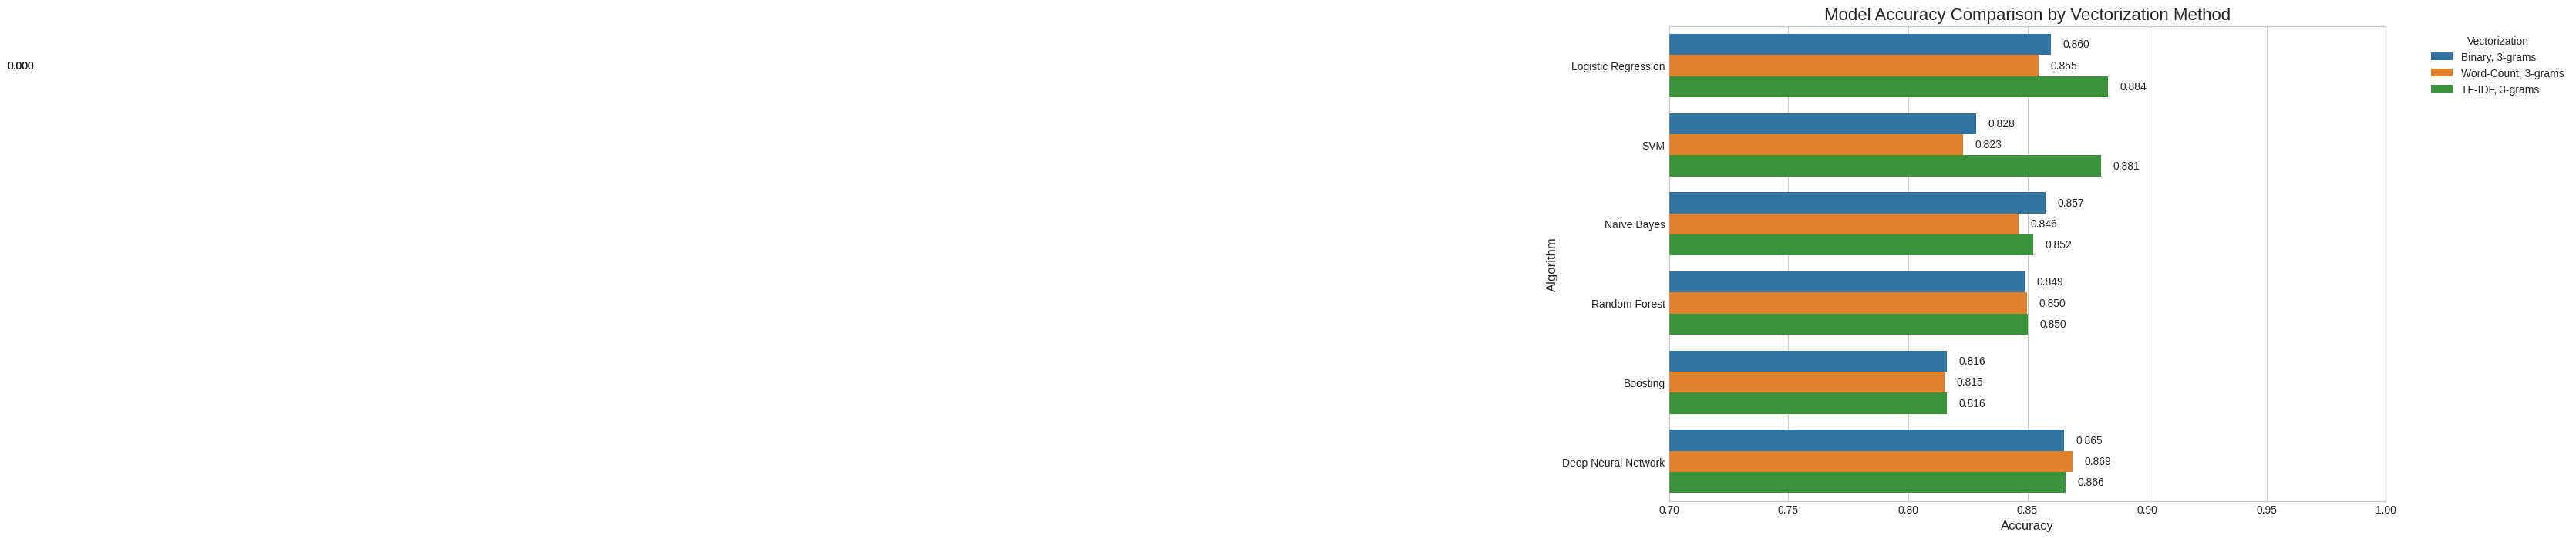

In [18]:
print("\n\n{'='*25} FINAL RESULTS SUMMARY {'='*25}")

# Create a pandas DataFrame from the results list
results_df = pd.DataFrame(results_list)
results_df = results_df.drop(columns=["Confusion Matrix"])

# Display the final results table, formatted to match the paper
print(results_df.round(3).to_string())

# --- Visualize the results ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=results_df, x='Accuracy', y='Algorithm', hue='Vectorization', ax=ax)
ax.set_title('Model Accuracy Comparison by Vectorization Method', fontsize=16)
ax.set_xlabel('Accuracy', fontsize=12)
ax.set_ylabel('Algorithm', fontsize=12)
ax.legend(title='Vectorization', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlim(0.7, 1.0)
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.005, p.get_y() + p.get_height() / 2, f'{width:.3f}', va='center')
plt.tight_layout()
plt.show()

6. DOCUMENT VECTOR VISUALIZATION WITH t-SNE



{'='*25} DOCUMENT VECTOR VISUALIZATION {'='*25}
Loading vectorizer from: trained_models/TF_IDF_3_grams_vectorizer.joblib
Transforming test data with the loaded vectorizer...
Running t-SNE on 2000 samples... (This may take a few minutes)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


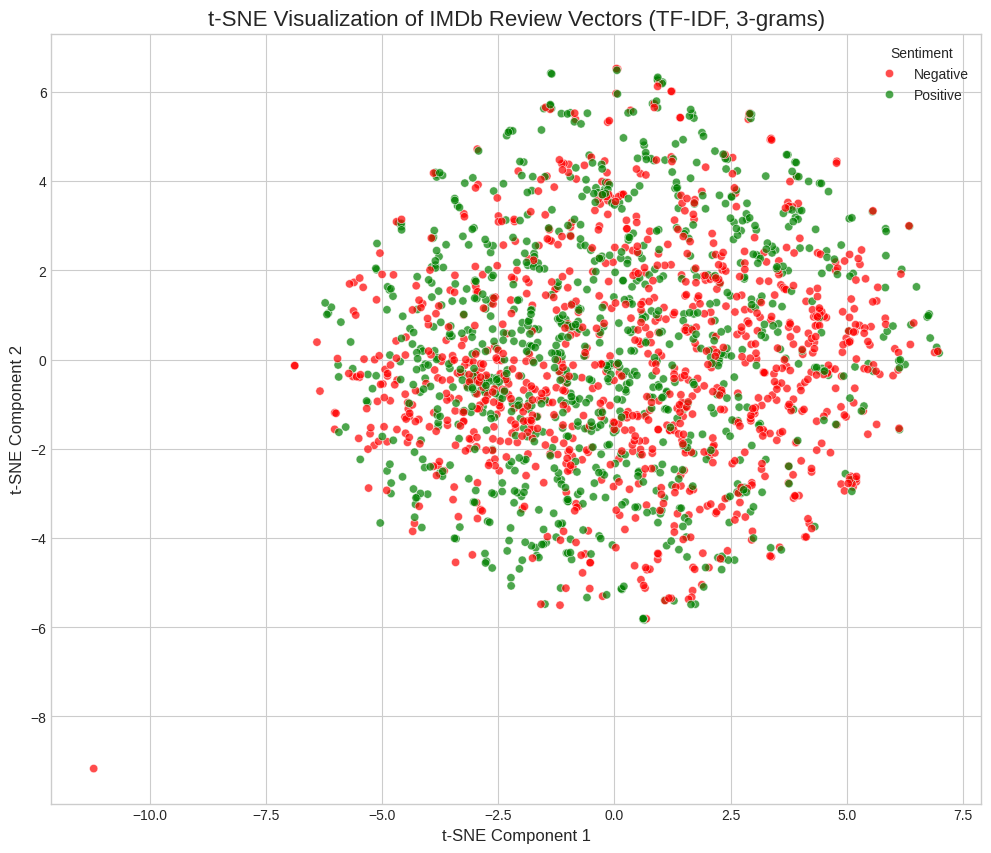

In [24]:
print("\n\n{'='*25} DOCUMENT VECTOR VISUALIZATION {'='*25}")

# --- Add a check for the necessary processed data from Section 2 ---
if 'X_test_processed' not in locals() or 'y_test' not in locals():
    print("\nERROR: Processed data ('X_test_processed', 'y_test') not found.")
    print("Please ensure you have run Section 1 and Section 2 to load and process the data before this step.")
else:
    try:
        # --- 1. Define path and load the specific vectorizer from disk ---
        vec_to_visualize = 'TF-IDF, 3-grams'
        vectorizer_filename = f"{vec_to_visualize.replace(', ', '_').replace('-', '_')}_vectorizer.joblib"
        vectorizer_path = os.path.join(models_dir, vectorizer_filename)

        print(f"Loading vectorizer from: {vectorizer_path}")
        loaded_vectorizer = joblib.load(vectorizer_path)

        # --- 2. Transform the test data using the loaded vectorizer ---
        print("Transforming test data with the loaded vectorizer...")
        test_vectors = loaded_vectorizer.transform(X_test_processed)

        # --- 3. Reduce sample size for faster t-SNE computation ---
        # t-SNE can be slow on 25,000 samples, so we'll use a random subset.
        num_samples = 2000
        random_indices = np.random.choice(test_vectors.shape[0], num_samples, replace=False)
        X_subset = test_vectors[random_indices]
        y_subset = y_test[random_indices]

        print(f"Running t-SNE on {num_samples} samples... (This may take a few minutes)")
        tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=300)
        X_tsne = tsne.fit_transform(X_subset.toarray())

        # --- 4. Plot the t-SNE results ---
        tsne_df = pd.DataFrame(data={
            'x': X_tsne[:, 0],
            'y': X_tsne[:, 1],
            'sentiment': ['Positive' if label == 1 else 'Negative' for label in y_subset]
        })

        plt.figure(figsize=(12, 10))
        sns.scatterplot(
            data=tsne_df,
            x='x',
            y='y',
            hue='sentiment',
            palette={'Positive': 'green', 'Negative': 'red'},
            alpha=0.7
        )
        plt.title(f't-SNE Visualization of IMDb Review Vectors ({vec_to_visualize})', fontsize=16)
        plt.xlabel("t-SNE Component 1", fontsize=12)
        plt.ylabel("t-SNE Component 2", fontsize=12)
        plt.legend(title="Sentiment")
        plt.show()

    except FileNotFoundError:
        print(f"\nERROR: Could not find the vectorizer file at '{vectorizer_path}'.")
        print("Please ensure that the models have been trained (Section 3) and the 'trained_models' directory exists with the saved vectorizer files.")

7. LIVE DEMO EXAMPLE CODE

In [25]:
print("\n\n{'='*25} LIVE DEMONSTRATION {'='*25}")

# --- 1. Load the best vectorizer and model from disk ---
# NOTE: For a local demo, you would first unzip 'trained_models_archive.zip'.
# This example assumes the files are available in the 'trained_models' directory.

# We'll choose the Binary, 3-grams vectorizer and the DNN model as an example
best_vectorizer_path = 'trained_models/Binary_3_grams_vectorizer.joblib'
best_model_path = 'trained_models/Binary_3_grams_DNN.h5'

print(f"Loading vectorizer from {best_vectorizer_path}...")
loaded_vectorizer = joblib.load(best_vectorizer_path)

print(f"Loading model from {best_model_path}...")
loaded_model = tf.keras.models.load_model(best_model_path)
print("Model and vectorizer loaded successfully.")

# --- 2. Create a prediction function using the loaded objects ---
def predict_sentiment_local(review_text):
    """
    Takes a raw review text and predicts its sentiment using the loaded pipeline.
    """
    # Preprocess the text
    processed_review = preprocess_text(review_text)
    # Vectorize the text using the LOADED vectorizer
    vectorized_review = loaded_vectorizer.transform([processed_review]).toarray()
    # Predict with the LOADED model
    prediction_proba = loaded_model.predict(vectorized_review)[0][0]
    sentiment = "Positive" if prediction_proba > 0.5 else "Negative"
    return sentiment, prediction_proba

# --- 3. Test with new reviews ---
new_reviews = [
    "This movie was absolutely fantastic! The acting was superb, the plot was gripping, and the ending was perfect. I would recommend this to everyone.",
    "What a complete waste of time. The movie was boring, the characters were flat, and the storyline was predictable. I regret watching this.",
    "It was an okay movie. Not great, but not terrible either. The special effects were good, but the story was a bit weak in the middle."
]

print("\n--- Predicting sentiment for new reviews using loaded models ---")
for review in new_reviews:
    sentiment, proba = predict_sentiment_local(review)
    print(f"\nReview: '{review}'")
    print(f"--> Predicted Sentiment: {sentiment} (Confidence: {proba:.2f})")



{'='*25} LIVE DEMONSTRATION {'='*25}
Loading vectorizer from trained_models/Binary_3_grams_vectorizer.joblib...
Loading model from trained_models/Binary_3_grams_DNN.h5...
Model and vectorizer loaded successfully.

--- Predicting sentiment for new reviews using loaded models ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step

Review: 'This movie was absolutely fantastic! The acting was superb, the plot was gripping, and the ending was perfect. I would recommend this to everyone.'
--> Predicted Sentiment: Positive (Confidence: 0.54)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Review: 'What a complete waste of time. The movie was boring, the characters were flat, and the storyline was predictable. I regret watching this.'
--> Predicted Sentiment: Negative (Confidence: 0.02)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Review: 'It was an okay movie. Not great, but not terrible either. The special effects were good, but the story was a bit weak in the middle.'
--> Predicted Sentiment: Negative (Confidence: 

8. Extras

In [26]:
!pip install wordcloud

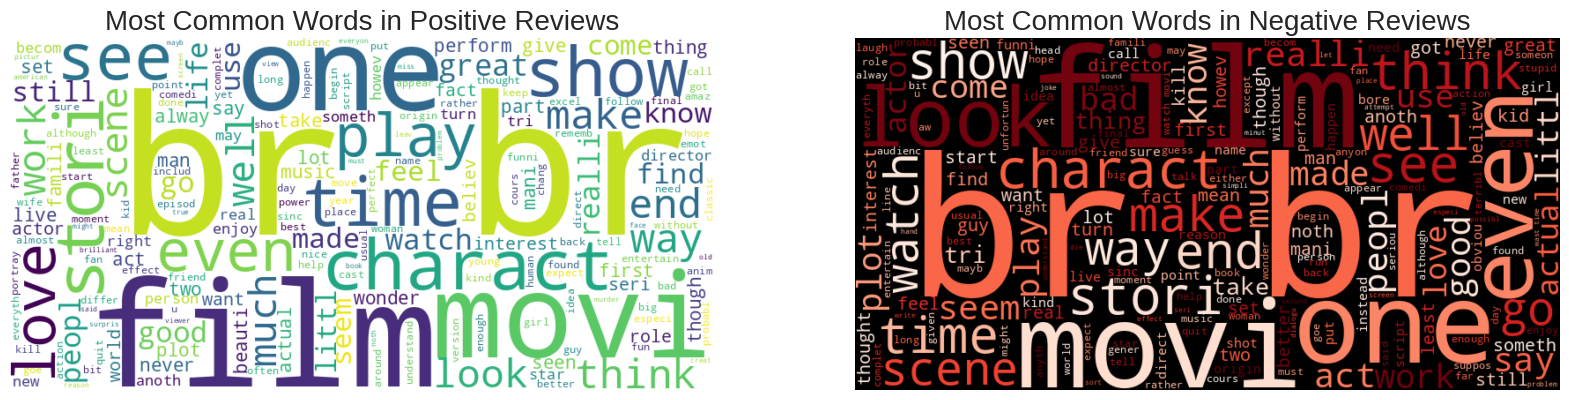

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# --- Combine all processed text for each sentiment ---
# Note: This assumes 'X_train_processed' and 'y_train' are available
positive_reviews_text = " ".join([review for i, review in enumerate(X_train_processed) if y_train[i] == 1])
negative_reviews_text = " ".join([review for i, review in enumerate(X_train_processed) if y_train[i] == 0])

# --- Generate Word Clouds ---
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_reviews_text)

# --- Plot the Word Clouds ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(positive_wordcloud, interpolation='bilinear')
ax1.set_title('Most Common Words in Positive Reviews', fontsize=20)
ax1.axis('off')

ax2.imshow(negative_wordcloud, interpolation='bilinear')
ax2.set_title('Most Common Words in Negative Reviews', fontsize=20)
ax2.axis('off')

plt.show()

/tmp/ipython-input-1585908818.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coefficient', y='feature', data=top_positive_features, ax=ax1, palette='Greens_r')
/tmp/ipython-input-1585908818.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coefficient', y='feature', data=top_negative_features.sort_values('coefficient', ascending=False), ax=ax2, palette='Reds_r')


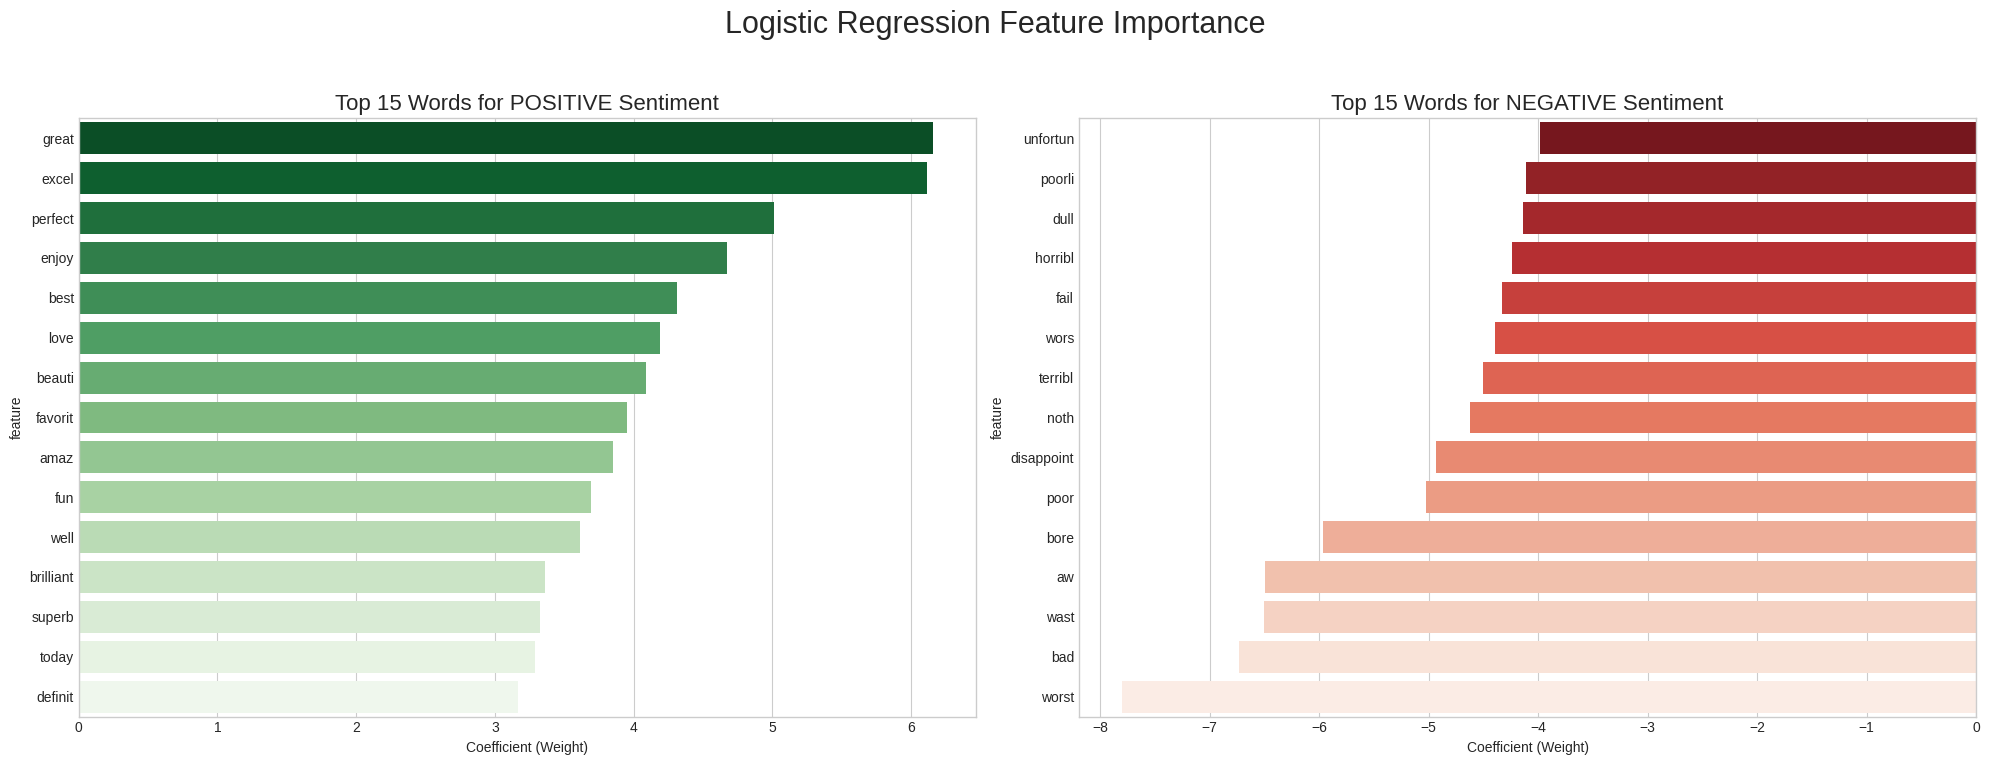

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- This requires a trained Logistic Regression model and a fitted vectorizer ---
# Example: Using the TF-IDF model and vectorizer
model_to_inspect_path = 'trained_models/TF_IDF_3_grams_Logistic_Regression.joblib'
vectorizer_to_inspect_path = 'trained_models/TF_IDF_3_grams_vectorizer.joblib'

# Load the model and vectorizer
lr_model = joblib.load(model_to_inspect_path)
tfidf_vectorizer = joblib.load(vectorizer_to_inspect_path)

# Get feature names and their corresponding coefficients
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = lr_model.coef_.flatten()

# Create a DataFrame
feature_importance_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})

# Get the top 15 positive and top 15 negative features
top_positive_features = feature_importance_df.nlargest(15, 'coefficient')
top_negative_features = feature_importance_df.nsmallest(15, 'coefficient')

# --- Plot the results ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.barplot(x='coefficient', y='feature', data=top_positive_features, ax=ax1, palette='Greens_r')
ax1.set_title('Top 15 Words for POSITIVE Sentiment', fontsize=16)
ax1.set_xlabel('Coefficient (Weight)')

sns.barplot(x='coefficient', y='feature', data=top_negative_features.sort_values('coefficient', ascending=False), ax=ax2, palette='Reds_r')
ax2.set_title('Top 15 Words for NEGATIVE Sentiment', fontsize=16)
ax2.set_xlabel('Coefficient (Weight)')

plt.suptitle('Logistic Regression Feature Importance', fontsize=22)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

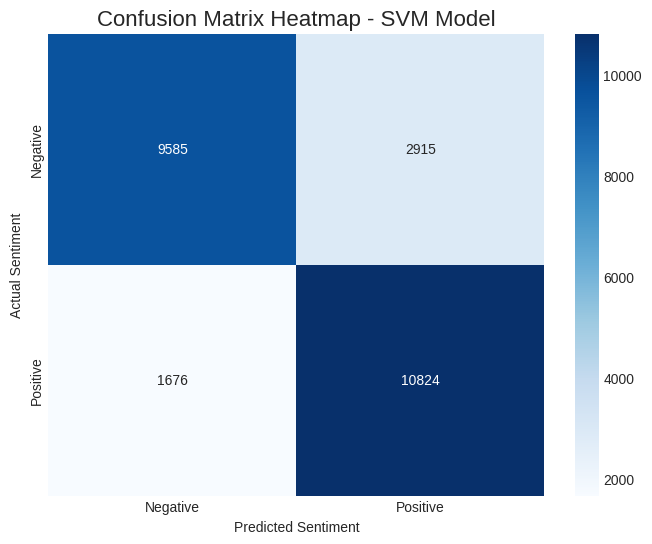

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- This requires 'y_test' and the predicted labels 'y_pred' from a model ---
# Example: let's assume y_pred is from your SVM model
# y_pred = svm_model.predict(X_test_vec)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# --- Plot the heatmap ---
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix Heatmap - SVM Model', fontsize=16)
plt.ylabel('Actual Sentiment')
plt.xlabel('Predicted Sentiment')
plt.show()